<hr>
<br><br><br>
<div align=center>
<font size=2>
        Trabalho de Conclusão de Curso
    </font>
    <br><br><BR>
    <font size=3>
        Classificação de sentimento em arquivos de áudio<br>a partir da extração de Coeficientes Cepstrais na frequência Mel<br>(MFCCs)
    </font>
    <br><br><BR>
    <font size=2>
        ICMC-USP
    </font>    
</div>
<br><br><br>
<hr>

<br><br>
<a id=menu></a>

[Biblotecas](#libs) <br>
[Dados](#data) <br>
[Pré-processamento](#prep) <br>
[Processamento](#proc) <br>
[Avaliação](#aval) <br>

<br>

<a id='libs'></a>
<h3>Bibliotecas</h3>
<br>
<blockquote>
<dl>
    <dl>- keras: interface para desenvolvimento de redes neurais.</dl>
    <dl>- librosa: múltiplas funcionalidades para tratamento de arquivos de áudio.</dl>
    <dl>- Matplotlib: criação de gráficos e visuadlzação de dados.</dl>
    <dl>- Numpy: processamento de vetores e matrizes multimensionais.</dl>
    <dl>- Pandas: manipulação e análise de dados tabulares e séries temporais</dl>
    <dl>- Seaborn: criação de gráficos e visualização de dados.</dl>
    <dl>- Sklearn: algoritmos de aprendizado de máquina.</dl>
    <dl>- TensorFlow: desenho de fluxos e processamento de tensores para aprendizado de máquina.</dl>
</dl>
<blockquote>

In [59]:
import numpy as np 
import pandas as pd 

import matplotlib.pyplot as plt 
import seaborn as sns


<br>
<a id='data'></a>
<h3>Dados</h3>

<font size=1>[menu](#menu)</font>

In [63]:
myDataTest = np.random.normal(1,.5,500)


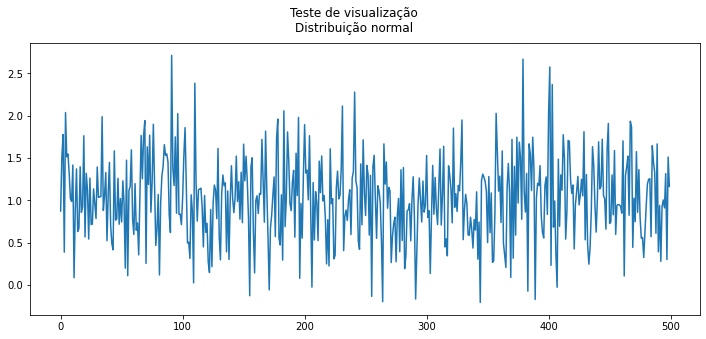

In [69]:
fig = plt.figure(figsize=(12,5))
sns.lineplot(data=myDataTest)
fig.suptitle('Teste de visualização\nDistribuição normal');

<br>
<a id='prep'></a>
<h3>Pré-processamento</h3>

<font size=1>[menu](#menu)</font>

<br>
<a id='proc'></a>
<h3>Processamento</h3>

<font size=1>[menu](#menu)</font>

<br>
<a id='aval'></a>
<h3>Avaliação</h3>

<font size=1>[menu](#menu)</font>

<hr>
<br><br>
<div align=right>
    <font size=2>
        Julio Valim &emsp;
    </font>
    <br>
    <font size=1>
        <a href='https://www.linkedin.com/in/juliovalim'>contato /in</a>&emsp;&emsp;
    </font>
</div>